In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [2]:
# Function to load and preprocess data
def load_data(filepath):
    # Load data
    data = pd.read_csv(filepath)
    data = data.dropna()  # Drop rows with missing values

    # Convert 'Satisfaction' to numeric and drop rows with NaN in 'Satisfaction'
    data['Satisfaction'] = pd.to_numeric(data['Satisfaction'], errors='coerce')
    data.dropna(subset=['Satisfaction'], inplace=True)

    return data

In [3]:
# Function to load and preprocess data
def load_test_data(filepath):
    # Load data
    data = pd.read_csv(filepath)
    data = data.dropna()  # Drop rows with missing values

    return data

In [4]:
# Function to create visualizations
def create_visualizations(data):
    # Boxplot for CO2 levels
    plt.figure()
    plt.boxplot(data['CO2_room'], showmeans=True)
    plt.title('CO2 in Room')
    plt.ylabel('CO2')
    plt.show()

    # Bar plot for average relative humidity
    indoor_humidity = data['Relative_humidity_room']
    outdoor_humidity = data['Outdoor_relative_humidity_Sensor']

    room_mean = np.mean(indoor_humidity)
    outdoor_mean = np.mean(outdoor_humidity)

    plt.figure()
    bar_width = 0.35
    bar_positions = np.arange(2)

    plt.bar(bar_positions[0], room_mean, bar_width, label='Room', color='skyblue')
    plt.bar(bar_positions[1], outdoor_mean, bar_width, label='Outdoor', color='lightgreen')

    plt.ylabel('Relative Humidity')
    plt.title('Average Relative Humidity in Room and Outdoor')
    plt.xticks(bar_positions, ['Room', 'Outdoor'])
    plt.legend()
    plt.show()

    # Line plot with trendline for indoor temperature
    indoor_temp = data['Indoor_temperature_room']

    plt.figure()
    plt.plot(data.index, indoor_temp, label='Indoor Temperature', color='blue')

    z = np.polyfit(x=data.index, y=indoor_temp, deg=1)
    p = np.poly1d(z)
    plt.plot(data.index, p(data.index), 'r--', label='Trendline')

    plt.title('Indoor Temperature in Room')
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.legend()
    plt.show()


In [5]:
# Function to build the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, activation='relu', input_shape=(input_shape, 1)))
    model.add(Dense(1))
    model.compile(loss='huber_loss', optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=['mse'])
    return model


In [6]:
# Function to train the model
def train_model(model, train_features, train_satisfaction, test_features, test_satisfaction):
    history = model.fit(
        train_features,
        train_satisfaction,
        epochs=10,
        batch_size=1,
        validation_data=(test_features, test_satisfaction),
        verbose=1
    )

    plt.figure()
    plt.plot(history.history['mse'], label='Training Loss')
    plt.plot(history.history['val_mse'], label='Validation Loss')
    plt.legend()
    plt.show()

    return history

In [7]:
# Function to evaluate the model's performance
def evaluate_model(model, test_features, test_satisfaction):
    test_predictions = model.predict(test_features)

    mse = mean_squared_error(test_satisfaction, test_predictions)
    mae = mean_absolute_error(test_satisfaction, test_predictions)
    r2 = r2_score(test_satisfaction, test_predictions)

    print(f"Mean Squared Error (MSE): {mse:.3f}")
    print(f"Mean Absolute Error (MAE): {mae:.3f}")
    print(f"R-squared: {r2:.3f}")

    plt.figure(figsize=(20, 5))
    plt.plot(test_satisfaction.values, label='Actual Satisfaction')
    plt.plot(test_predictions, label='Predicted Satisfaction')
    plt.legend(loc='best')
    plt.title("Comparison of Actual and Predicted Satisfaction")
    plt.show()

    return test_predictions

In [8]:
# Function to evaluate the model's performance
def predict_test_model(model, test_features):
    test_predictions = model.predict(test_features)
    return test_predictions

In [9]:
# Functions for ventilation and storage heater
def mechanical_ventilation(outdoor_temp, outdoor_humidity):
    return outdoor_temp, outdoor_humidity

In [10]:
# Functions for ventilation and storage heater
def storage_heater(indoor_temp):
    return indoor_temp + 0.5

In [122]:
last_use_time = None
uses_today = 0

In [123]:
def check_storage_heater_availability(current_time):
    global last_use_time, uses_today

    print("Current Time:", current_time)
    print("Last Use Time:", last_use_time)
    print("Uses Today:", uses_today)

    if last_use_time is None or last_use_time.date() != current_time.date():
        print("New Day Detected")
        # Reset uses counter for the new day
        uses_today = 0

    # Check if less than 2 uses have been made today and Check if at least 4 hours have passed since the last use
    if uses_today < 2 and (last_use_time is None or (current_time - last_use_time) >= datetime.timedelta(hours=4)):
        print("Storage Heater Available")
        return True

    print("Storage Heater Not Available")
    return False

In [124]:
# Function to adjust indoor environment
def adjust_indoor_environment(test, predictions, new_test_features):
    global last_use_time, uses_today
    output_data = []
    average_satisfaction_threshold = 95  # Threshold for deciding when adjustments are needed

    for i in range(len(test)):
        time = test.iloc[i]['Time']
        date = test.iloc[i]['Date']
        
         # Explicitly parsing the DateTime with format specification
        test['DateTime'] = pd.to_datetime(test['Date'] + ' ' + test['Time'], format='%d/%m/%Y %H:%M')
    
        co2_level = new_test_features.iloc[i]['CO2_room']
        indoor_temp = new_test_features.iloc[i]['Indoor_temperature_room']
        indoor_humidity = new_test_features.iloc[i]['Relative_humidity_room']
        outdoor_temp = new_test_features.iloc[i]['Outside temp']
        outdoor_humidity = new_test_features.iloc[i]['Outdoor_relative_humidity_Sensor']
        satisfaction = predictions[i][0]
        current_time = test.iloc[i]['DateTime']

        # Check if satisfaction is below threshold
        if satisfaction < average_satisfaction_threshold:
            # If outdoor temperature is higher than indoor temperature, consider heating
            if outdoor_temp > indoor_temp:
                if check_storage_heater_availability(current_time):
                    # Adjust indoor temperature with storage heater
                    for t in range(i, min(i + 16, len(test))):
                        new_test_features.iloc[t]['Indoor_temperature_room'] += 0.5
                    last_use_time = current_time
                    uses_today += 1

            else:
                # Consider humidity levels for ventilation
                if outdoor_humidity < indoor_humidity:
                    # If outdoor humidity is lower, use mechanical ventilation to lower indoor humidity
                    indoor_temp, indoor_humidity = mechanical_ventilation(outdoor_temp, outdoor_humidity)
                    co2_level = 250
                else:
                    # If outdoor humidity is higher, leave indoor environment as-is to avoid increasing indoor humidity
                    indoor_temp = indoor_temp
                    indoor_humidity = indoor_humidity

        # Default action when satisfaction is above threshold
        else:
            indoor_temp = indoor_temp
            indoor_humidity = indoor_humidity

        output_data.append([date, time, co2_level, indoor_temp, indoor_humidity, satisfaction])

    return output_data


In [14]:
# Main execution logic
train = load_data("train.csv")

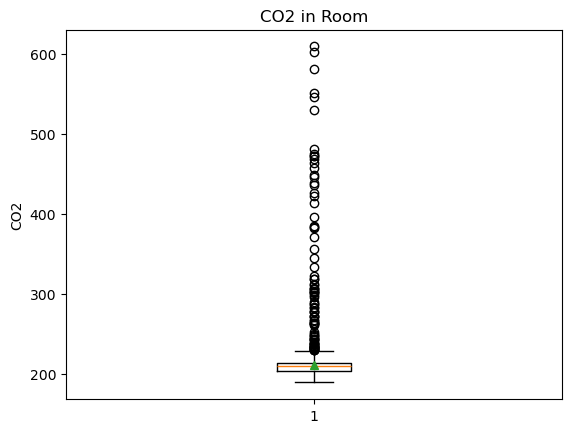

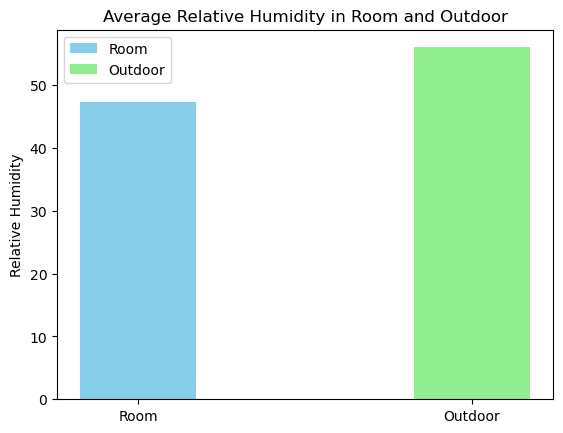

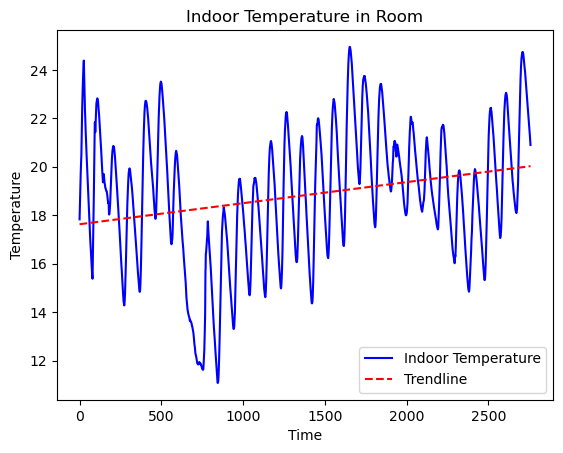

In [15]:
# Visualization
create_visualizations(train)

In [16]:
# Select features and target
features = ['Indoor_temperature_room', 'Outside temp', 'CO2_room', 'Outdoor_relative_humidity_Sensor', 'Relative_humidity_room']
train_features, test_features, train_satisfaction, test_satisfaction = train_test_split(
    train[features],
    train['Satisfaction'],
    test_size=0.2,
    random_state=42
)

In [17]:
scaler = MinMaxScaler()
scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)

Epoch 1/10
2204/2204 [==============================] - 28s 10ms/step - loss: 19.3663 - mse: 809.5790 - val_loss: 12.5600 - val_mse: 307.5981
Epoch 2/10
2204/2204 [==============================] - 21s 10ms/step - loss: 8.6353 - mse: 163.6209 - val_loss: 6.4776 - val_mse: 119.7758
Epoch 3/10
2204/2204 [==============================] - 19s 9ms/step - loss: 6.2167 - mse: 106.6635 - val_loss: 5.0876 - val_mse: 94.1439
Epoch 4/10
2204/2204 [==============================] - 23s 10ms/step - loss: 5.9244 - mse: 106.4244 - val_loss: 6.7825 - val_mse: 137.1349
Epoch 5/10
2204/2204 [==============================] - 21s 10ms/step - loss: 5.9852 - mse: 105.6982 - val_loss: 5.1317 - val_mse: 86.6134
Epoch 6/10
2204/2204 [==============================] - 21s 10ms/step - loss: 5.7674 - mse: 99.8234 - val_loss: 5.7700 - val_mse: 109.3428
Epoch 7/10
2204/2204 [==============================] - 21s 9ms/step - loss: 5.5275 - mse: 92.7375 - val_loss: 5.1459 - val_mse: 90.5392
Epoch 8/10
2204/2204 [===

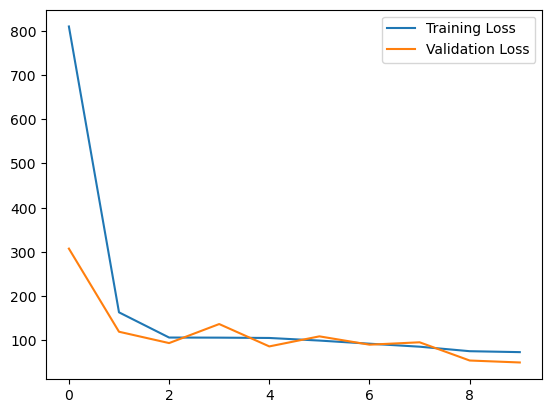

In [18]:
# Build and train the LSTM model
model = build_lstm_model(scaled_train_features.shape[1])
history = train_model(model, scaled_train_features, train_satisfaction, scaled_test_features, test_satisfaction)

18/18 [==============================] - 1s 6ms/step
Mean Squared Error (MSE): 50.308
Mean Absolute Error (MAE): 4.670
R-squared: 0.562


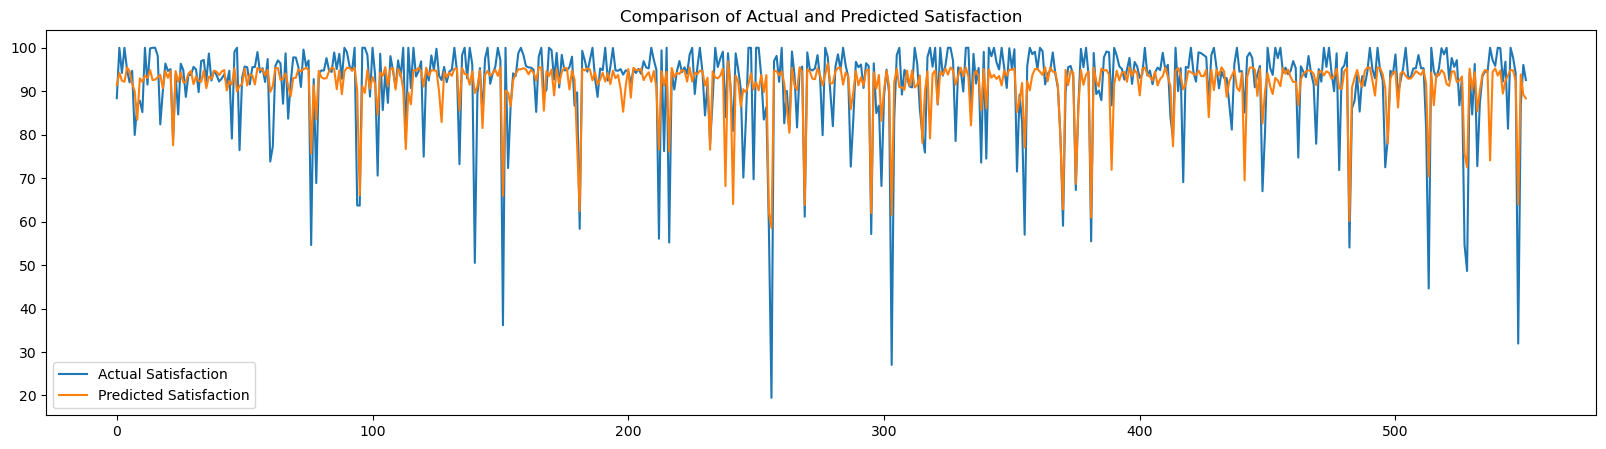

In [19]:
# Evaluate the model and make predictions
test_predictions = evaluate_model(model, scaled_test_features, test_satisfaction)

In [125]:
# Load and preprocess test data
test = load_test_data("test.csv")
new_test_features = test[features]
scaled_new_test_features = scaler.transform(new_test_features)

In [126]:
new_test_predictions = predict_test_model(model, scaled_new_test_features)

3/3 [==============================] - 0s 3ms/step


In [127]:
# Adjust indoor environment based on predictions
output_data = adjust_indoor_environment(test, new_test_predictions, new_test_features)

Current Time: 2012-04-12 01:15:00
Last Use Time: None
Uses Today: 0
New Day Detected
Storage Heater Available
Current Time: 2012-04-12 05:45:00
Last Use Time: 2012-04-12 01:15:00
Uses Today: 1
Storage Heater Available
Current Time: 2012-04-12 09:15:00
Last Use Time: 2012-04-12 05:45:00
Uses Today: 2
Storage Heater Not Available
Current Time: 2012-04-12 18:15:00
Last Use Time: 2012-04-12 05:45:00
Uses Today: 2
Storage Heater Not Available


In [128]:
# Create a DataFrame for output and write to CSV
output_df = pd.DataFrame(output_data, columns=['Date', 'Time', 'CO2_Level', 'Indoor_Temperature', 'Indoor_Humidity', 'Satisfaction'])
output_df.to_csv("predicted_test.csv", index=False)